# River pollution probelm (all objectives minimized)

In [3]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from desdeo_problem.problem import DiscreteDataProblem
from desdeo_tools.scalarization import SimpleASF, DiscreteScalarizer, StomASF, PointMethodASF
from desdeo_tools.solver import DiscreteMinimizer
from shapley_values.explanations import *
from shapley_values.utilities import *
from IPython.core.display import display, HTML


# Load and setup problem
df = pd.read_csv("../data/river_pollution_2500.csv")
pareto_front = df.to_numpy()

ideal = np.min(pareto_front[:, 0:5], axis=0)
nadir = np.max(pareto_front[:, 0:5], axis=0)

objective_names = ["f_1", "f_2", "f_3", "f_4", "f_5"]
n_objectives = len(objective_names)

problem = DiscreteDataProblem(df, ["x_1", "x_2"], objective_names, nadir, ideal)

# asf = SimpleASF(np.array([1,1,1,1,1]))
asf = StomASF(ideal)
# asf = PointMethodASF(nadir, ideal)

missing_data = shap.sample(pareto_front[:, 0:n_objectives], nsamples=200)

# need to know reference point before generating missing data
bb = generate_black_box(problem, asf)
explainer = shap.KernelExplainer(bb, missing_data)

normalizer = Normalizer(ideal, nadir)

def plot(result, objective_names=objective_names, ymin=0, ymax=1):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim(ymin, ymax)
    ax.bar(objective_names, np.squeeze(result)) 
    plt.grid()
    plt.show()

print(f"Ideal: {ideal}")
print(f"Nadir: {nadir}")
print(np.abs(nadir - ideal))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Ideal: [-6.34000000e+00 -2.86434153e+00 -7.50000000e+00 -1.16266667e+01
  8.00540857e-03]
Nadir: [-4.751      -2.76221532 -0.32111111 -1.92        0.35      ]
[1.589      0.10212621 7.17888889 9.70666667 0.34199459]


## Initial solution

Reference point: [-5.5455     -2.81327842 -3.91055556 -6.77333333  0.1790027 ]


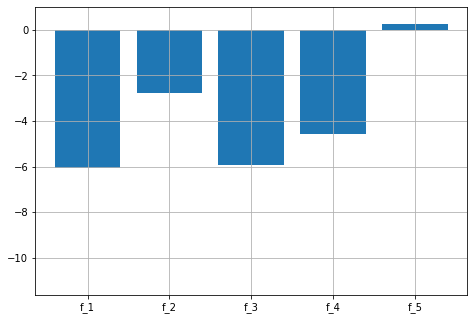

Result: [[-6.06902002 -2.79626487 -5.95243843 -4.5917756   0.25866192]]
SHAP values:
[[ 0.04674455 -0.14583724 -0.38018785 -0.02778602  0.08938361]
 [ 0.00227788 -0.00261115 -0.00616064  0.0101717   0.00162095]
 [-0.40494449  0.27919554  0.76189735  0.26579816 -0.85141305]
 [ 0.0904603   0.10859441  0.04114292 -0.34503531  0.64144317]
 [-0.00919999 -0.00708386 -0.00634586  0.02711984 -0.02018444]]


In [4]:
result = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
plot(result, ymin=np.min(ideal))
print(f"Result: {result}")
print(f"SHAP values:\n{shap_values}")

## How to improve the initial solution

In [5]:
to_improve = 3
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, result)

display(HTML(f"<h3>Suggestion</h3><p style=font-size:20px>{suggestion_str}</p>"))

## New reference point and missing data

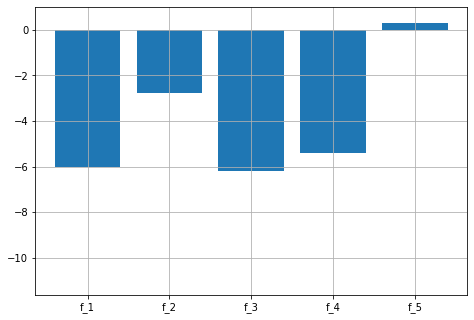

[[-6.01777053 -2.7922812  -6.20294674 -5.3885912   0.28446604]]


In [7]:
delta_mult = 0.1
deltas = (nadir - ideal)*delta_mult

new_ref_point = np.copy(ref_point)
new_ref_point[3] -= deltas[3]
new_ref_point[1] += deltas[1]

new_result = bb(np.atleast_2d(new_ref_point))

plot(new_result, ymin=np.min(ideal))
print(new_result)

## Differences

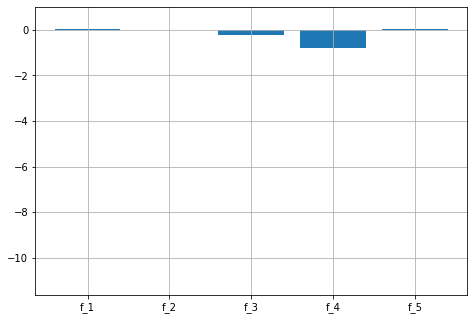

In [8]:
plot(new_result - result, ymin=np.min(ideal))